In [1]:
# data processing
import numpy as np
import os
import sys
import pandas as pd
import pickle

# Machine learning library
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, roc_curve, auc

# data visualizations
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# Get unprocessed data
dataset = getCSVData(Location.health_data_raw)
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
# get the data
X_train, X_test, Y_train, Y_test = getProcessedData(Location.health_data_process)


In [6]:
# Standardize features. Require for Machine learning
sc = StandardScaler()
# Fit to data, then transform it
X_train = sc.fit_transform(X_train)
sc.mean_


array([  3.9675    , 125.415     ,  69.9575    ,  20.7275    ,
        82.57      ,  32.82390233,   0.48045628,  34.03875   ])

In [7]:
sc.scale_

array([  3.25022211,  32.69258746,  19.92650731,  16.00049198,
       118.07248875,   7.4502032 ,   0.31149059,  11.54901504])

In [8]:
# Perform standardization by centering and scaling
X_test = sc.transform(X_test)
X_test

array([[-0.29767196, -0.04328198,  0.50397693, ...,  0.05048153,
        -0.56327956, -0.69605503],
       [ 1.24068444, -1.84797242,  0.10250166, ..., -0.1105879 ,
         0.38377955,  0.6893445 ],
       [ 2.16369828, -0.16563388,  0.50397693, ...,  1.27192473,
         0.97769798,  1.20886932],
       ...,
       [-0.91301453, -0.89974524, -0.29897362, ...,  0.05048153,
        -0.61464548, -1.12899238],
       [ 0.62534188, -0.62445348,  0.50397693, ..., -0.04347564,
         1.27626238, -0.69605503],
       [-1.22068581,  0.17083383, -3.51077582, ...,  1.3927268 ,
        -0.67564251, -0.69605503]])

In [9]:
# Init an H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Microsoft-25199 (build 11.0.12+7, mixed mode)
  Starting server from C:\Python311\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\ADMINI~1\AppData\Local\Temp\tmp2g1par0q
  JVM stdout: C:\Users\ADMINI~1\AppData\Local\Temp\tmp2g1par0q\h2o_Administrator_started_from_python.out
  JVM stderr: C:\Users\ADMINI~1\AppData\Local\Temp\tmp2g1par0q\h2o_Administrator_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,18 secs
H2O_cluster_timezone:,Asia/Jerusalem
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.40.0.1
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_Administrator_71jcrd
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.945 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [10]:
# Convert training data to H2OFrame
# the train result will be used to train a machine learning model
train = h2o.H2OFrame(np.concatenate((X_train, Y_train.values.reshape(-1, 1)), axis=1))
train.columns = list(dataset.columns)
train[ProcessConfig.health_label] = train[ProcessConfig.health_label].asfactor()

# Specify target variable and predictor variables
x = train.columns[:-1]
y = train.columns[-1]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
# Run H2O AutoML to automatically select, train and optimize SVM model
aml = H2OAutoML(max_models=10, sort_metric='mse', max_runtime_secs=5 * 60, seed=666)
aml.train(x=x, y=y, training_frame=train)

AutoML progress: |
13:00:58.533: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,cross_validation
Number of base models (used / total),4/5
# GBM base models (used / total),1/1
# DRF base models (used / total),2/2
# DeepLearning base models (used / total),1/1
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5
Metalearner fold_column,None


In [12]:
# View the leaderboard of trained models
lb = aml.leaderboard
print(lb.head())

model_id                                                      mse       auc    logloss     aucpr    mean_per_class_error      rmse
StackedEnsemble_BestOfFamily_1_AutoML_1_20230226_130058  0.136093  0.888509   0.416258  0.889914                0.194745  0.368908
StackedEnsemble_AllModels_1_AutoML_1_20230226_130058     0.136502  0.887934   0.416998  0.890195                0.197257  0.369462
XRT_1_AutoML_1_20230226_130058                           0.136697  0.888771   0.421388  0.889645                0.202308  0.369725
DRF_1_AutoML_1_20230226_130058                           0.139249  0.883806   0.425792  0.885763                0.198567  0.373161
GBM_4_AutoML_1_20230226_130058                           0.142478  0.87703    0.439785  0.875106                0.196229  0.377463
GBM_grid_1_AutoML_1_20230226_130058_model_1              0.142773  0.881402   0.435694  0.8842                  0.213411  0.377853
GBM_5_AutoML_1_20230226_130058                           0.143556  0.876624   0.442

In [13]:
# Use the best model to predict on test data
model = aml.leader
X_h2o = h2o.H2OFrame(X_test)
X_h2o.columns = list(dataset.columns)[:-1]
y_pred = model.predict(X_h2o).as_data_frame().values.flatten()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [14]:
# Train a PySVM SVM model
model = LinearSVC(random_state=0, tol=1e-5, max_iter=10000, dual=False)
Y_pred = model.fit(X_train, Y_train)

In [16]:
# Test the model on the test data
y_pred = model.predict(X_test)
misclassified = np.where(Y_test != y_pred)[0]
print("Indices of potentially misclassified instances: ", misclassified)

Indices of potentially misclassified instances:  [  3   5   8  13  14  20  30  33  35  37  40  43  46  53  54  55  60  61
  65  68  70  81  83  85  89  91  93  95 111 113 114 116 117 119 123 131
 140 141 143 144 147 148 149 152 153 156 159 170 171 174 176 181]


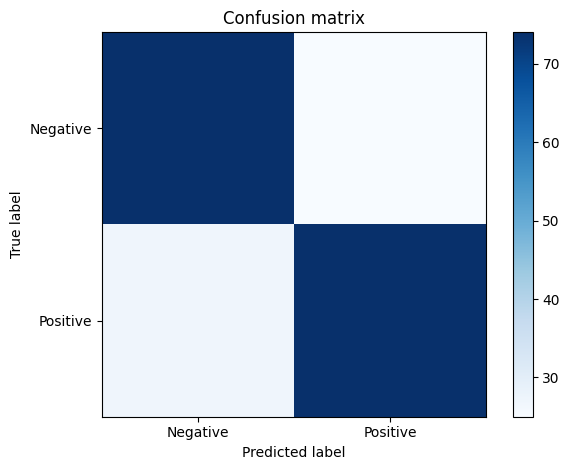

In [17]:
# Confusion matrix - summarizing the performance of a classification algorithm.
cm = confusion_matrix(Y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0, 1], ["Negative", "Positive"])
plt.yticks([0, 1], ["Negative", "Positive"])
plt.tight_layout()
plt.show()

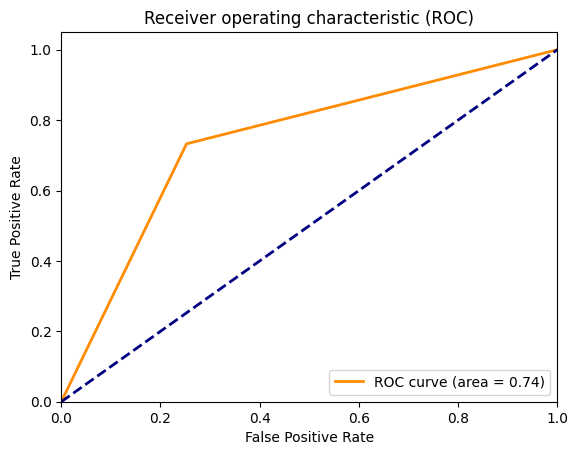

In [18]:
# ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()